In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import os


folder = "./data/numpy_bitmap/" # Data Location
n_files_to_load = 4 # Number of classes for data
random_state = 42 # Reproduce same classes each time this is run

# All files in data folder
all_files = [f for f in os.listdir(folder) if f.endswith(".npy")]

# Shuffle files reproducibly
rng = np.random.default_rng(seed = random_state)
rng.shuffle(all_files)

all_sketches_flat = []
all_labels = []

# Getting files to load
files_to_process = all_files[:n_files_to_load]
print(f"Loading sketches from {len(files_to_process)} files in {folder}...")

# Load and Flatten Sketches
for i, file in enumerate(files_to_process):
    label = os.path.splitext(file)[0]
    sketches_array = np.load(os.path.join(folder, file))
    
    # Flatten the 28x28 images into a 784-element feature vector
    sketches_flat = sketches_array.reshape(sketches_array.shape[0], -1)
    
    all_sketches_flat.append(sketches_flat)
    all_labels.extend([label] * sketches_array.shape[0])

# Concatenate all loaded arrays into one large array
combined_sketches = np.vstack(all_sketches_flat)
print(f"\nTotal loaded sketches: {combined_sketches.shape[0]} (Features: {combined_sketches.shape[1]})")

# Normalization
print("Normalizing pixel data (0-255 -> 0.0-1.0)")
combined_sketches_normalized = combined_sketches.astype(np.float32) / 255.0
print("Normalization complete")

# Create the DataFrame using the normalized array
df = pd.DataFrame(combined_sketches_normalized)
df['label'] = all_labels

# Shuffle the entire dataset
df = shuffle(df, random_state = random_state).reset_index(drop = True)

# Rename the pixel columns for clarity
df.columns = [f'pixel_{j}' for j in range(df.shape[1] - 1)] + ['label']

# df is now the COMPLETE ML-ready dataset.
print("\nFinal ML-Ready Dataset:")
print(f"Shape: {df.shape} (All loaded sketches, 784 pixel features + 1 label)")
print(f"Number of classes: {len(df['label'].unique())}\n")

# Train-test split
X = df.iloc[:, :-1]
y = df.iloc[:, [-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
train_data = pd.concat([X_train, y_train], axis = 1)
test_data = pd.concat([X_test, y_test], axis = 1)

# Split a DataFrame into n_parts and save each as Parquet.
def save_in_parts(df, base_name, n_parts = 5):
    total_rows = df.shape[0]
    rows_per_part = int(np.ceil(total_rows / n_parts))

    for i in range(n_parts):
        start = i * rows_per_part
        end = min((i + 1) * rows_per_part, total_rows)
        part_df = df.iloc[start:end]
        file_path = f"./data/{base_name}_part{i+1}.parquet"
        part_df.to_parquet(file_path, index = False)
        print(f"Saved {file_path} ({part_df.shape[0]} rows)")

# Save training data
save_in_parts(train_data, "training_data", n_parts=5)
print("Saved training data to data folder in 5 parts\n")

# Save testing data
save_in_parts(test_data, "testing_data", n_parts=5)
print("Saved testing data to data folder in 5 parts")

Loading sketches from 4 files in ./data/numpy_bitmap/...

Total loaded sketches: 657705 (Features: 784)
Normalizing pixel data (0-255 -> 0.0-1.0)
Normalization complete

Final ML-Ready Dataset:
Shape: (657705, 785) (All loaded sketches, 784 pixel features + 1 label)
Number of classes: 4

Saved ./data/training_data_part1.parquet (105233 rows)
Saved ./data/training_data_part2.parquet (105233 rows)
Saved ./data/training_data_part3.parquet (105233 rows)
Saved ./data/training_data_part4.parquet (105233 rows)
Saved ./data/training_data_part5.parquet (105232 rows)
Saved training data to data folder in 5 parts

Saved ./data/testing_data_part1.parquet (26309 rows)
Saved ./data/testing_data_part2.parquet (26309 rows)
Saved ./data/testing_data_part3.parquet (26309 rows)
Saved ./data/testing_data_part4.parquet (26309 rows)
Saved ./data/testing_data_part5.parquet (26305 rows)
Saved testing data to data folder in 5 parts


Visualizing 20 random sketches...


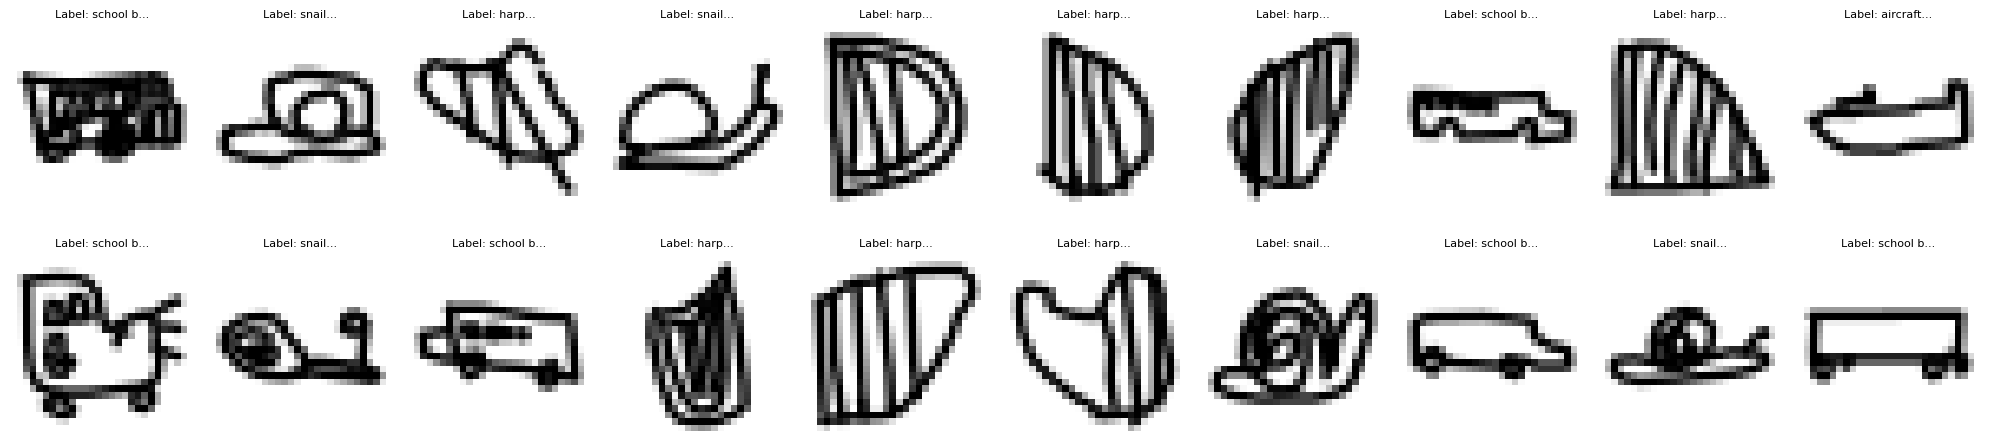

In [2]:
import matplotlib.pyplot as plt

N_IMAGES = 20
N_COLS = 10  # Arrange plots in a 2x4 grid
N_ROWS = int(np.ceil(N_IMAGES / N_COLS))

# Sample N_IMAGES random rows from the DataFrame
df_sample = df.sample(n=N_IMAGES).reset_index(drop=True)

# Set up the plot grid
fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(20, 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

print(f"Visualizing {N_IMAGES} random sketches...")

# Loop through the sample and plot each sketch
for i in range(N_IMAGES):
    sketch_data = df_sample.iloc[i]

    # Separate label and pixel data
    label = sketch_data['label']
    pixel_features = sketch_data.drop('label').values
    
    # Ensure correct numerical type
    pixel_features = pixel_features.astype(np.float32)

    # Reshape the 784 features into a 28x28 image
    image_matrix = pixel_features.reshape(28, 28)

    # Plot the image on the corresponding subplot
    axes[i].imshow(image_matrix, cmap = 'gray_r') # 'gray_r' ensures ink (low values) is black
    axes[i].set_title(f"Label: {label[:8]}...", fontsize = 8)
    axes[i].axis('off')

# Hide any unused subplots (if N_IMAGES is less than N_ROWS * N_COLS)
for j in range(N_IMAGES, N_ROWS * N_COLS):
    axes[j].axis('off')

plt.tight_layout()
plt.show()